In [1]:
from celegans_connectome_analysis.get_nx import get_adult_c_elegans_nx
import networkx as nx
import graspologic as gl
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

/Users/thomasathey/Documents/shavit-lab/celegans/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
G = get_adult_c_elegans_nx()

/Users/thomasathey/Documents/shavit-lab/celegans/celegans_connectome_analysis/celegans_connectome_analysis/get_nx.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["neuron type"] = df["neuron type"].fillna(method='ffill')


In [7]:
sensory_list = [n for n in G.nodes if G.nodes[n]["neuron type"] == "Sens."]
interneuron_list = [n for n in G.nodes if G.nodes[n]["neuron type"] == "Inter."]

mp = len(sensory_list)
print(f"Number of features m': {mp}")
print(f"Number of [inter]neurons n: {len(interneuron_list)} vs. sqrt(m' log m'): {np.sqrt(mp * np.log(mp))}")

Number of features m': 65
Number of [inter]neurons n: 44 vs. sqrt(m' log m'): 16.472254628411267


In [4]:
adjacency_matrix = np.zeros((len(sensory_list), len(interneuron_list)))
for i, s in enumerate(sensory_list):
    for j, inter in enumerate(interneuron_list):
        if G.has_edge(s, inter):
            adjacency_matrix[i, j] = G[s][inter]['weight'] > 0

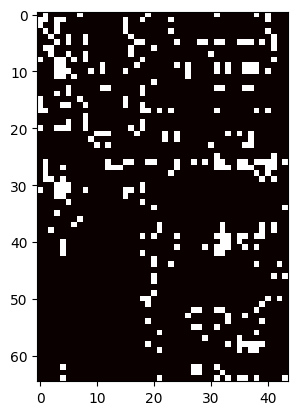

In [5]:
plt.imshow(adjacency_matrix, cmap='hot', interpolation='nearest')

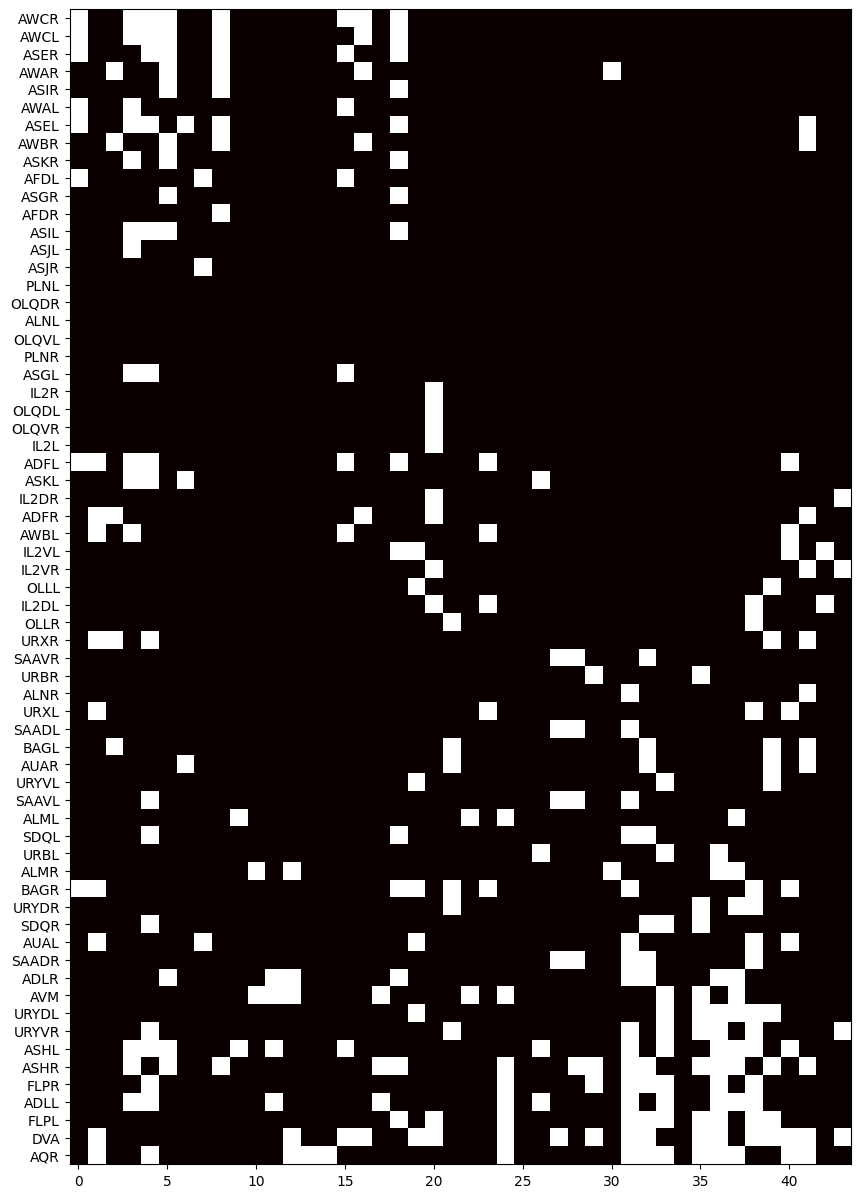

In [6]:
pca = PCA(n_components=1)
transformed_adj = pca.fit_transform(adjacency_matrix)
sorted_tadj = np.argsort(transformed_adj, axis=0)

matrix_obs = adjacency_matrix[sorted_tadj[:,0],:]

sorted_sensory_list = [sensory_list[i] for i in sorted_tadj[:,0]]

plt.figure(figsize=(15, 15))
plt.imshow(matrix_obs, cmap='hot', interpolation='nearest')
plt.yticks(range(len(sorted_sensory_list)), sorted_sensory_list)
plt.show()


In [7]:
def mean_closest_distance(matrix):
    distances = []

    for i in range(matrix.shape[0]):
        row = matrix[i,:]
        other_rows = np.delete(matrix, i, axis=0)
        distances.append(np.min(np.linalg.norm(row - other_rows, axis=1)))


    return np.mean(distances)


def permute_columns(matrix):
    permuted_matrix = matrix.copy()
    for i in range(matrix.shape[0]):
        permuted_matrix[i,:] = np.random.permutation(matrix[i,:])
    return permuted_matrix

In [8]:
mean_closest_distance(np.ones((10,20)))

0.0

In [9]:
stat_obs = mean_closest_distance(matrix_obs)

distances_permute = [stat_obs]
for i in tqdm(range(10000)):
    permuted_matrix = permute_columns(matrix_obs)
    stat_permute = mean_closest_distance(permuted_matrix)
    distances_permute.append(stat_permute)
    

# compute a p-value, the fraction of permuted distances that are less than the observed distance
p_value = np.mean(np.array(distances_permute) <= stat_obs)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Mean closest distance between sensory connectivity (binarized, to interneurons)')

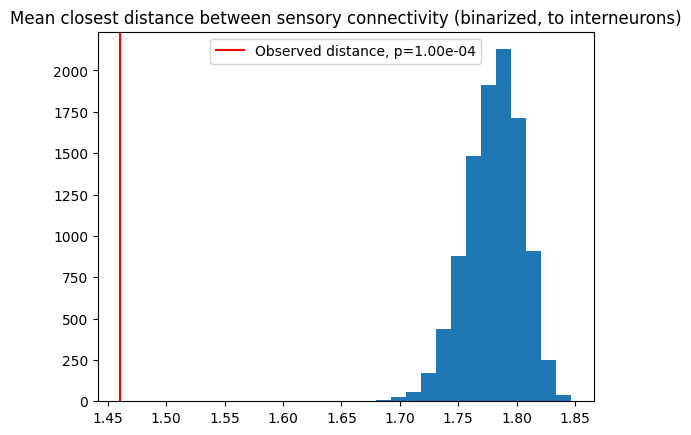

In [11]:
# plot a histogram of the permuted distances
# plot a vertical line at the observed distance

plt.hist(distances_permute, bins=30)
plt.axvline(mean_closest_distance(matrix_obs), color='red', label=f'Observed distance, p={p_value:.2e}')
plt.legend()
plt.title('Mean closest distance between sensory connectivity (binarized, to interneurons)')